## 基于DPN模型实现骨折识别

该项目基于 DPN 算法，判断是否有骨折。

### 环境准备

In [1]:
%%capture captured_output
!pip uninstall mindspore -y
%env MINDSPORE_VERSION=2.5.0
!pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/${MINDSPORE_VERSION}/MindSpore/unified/aarch64/mindspore-${MINDSPORE_VERSION}-cp39-cp39-linux_aarch64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.tuna.tsinghua.edu.cn/simple

In [2]:
# 查看当前 mindspore 版本
!pip show mindspore

Name: mindspore
Version: 2.5.0
Summary: MindSpore is a new open source deep learning training/inference framework that could be used for mobile, edge and cloud scenarios.
Home-page: https://www.mindspore.cn
Author: The MindSpore Authors
Author-email: contact@mindspore.cn
License: Apache 2.0
Location: /home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages
Requires: asttokens, astunparse, dill, numpy, packaging, pillow, protobuf, psutil, safetensors, scipy
Required-by: 


### 超参设置

In [3]:
batch_size = 64  # 批量大小
image_size = 64  # 训练图像空间大小
workers = 4  # 并行线程个数
num_classes = 2  # 分类数量

### 数据集下载及数据处理

通过git下载魔乐平台的数据集。

In [4]:
!git lfs install
!git clone https://modelers.cn/xsir/fractured.git
!unzip -q fractured/dataset.zip -d ./fractured

Git LFS initialized.
正克隆到 'fractured'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 13 (delta 3), reused 0 (delta 0), pack-reused 0
接收对象中: 100% (13/13), 完成.
处理 delta 中: 100% (3/3), 完成.


因为数据集里面有些png图片是包含ICCP配置的，而libpng加载时会有警告提示，所以在这里对相关图片进行处理：

In [5]:
import os
from PIL import Image
from tqdm import tqdm  # 可选：用于显示进度条

def remove_icc_profile(image_path):
    """移除单张图片的 ICC 配置并覆盖保存"""
    try:
        with Image.open(image_path) as img:
            # 检查是否存在 ICC 配置
            if "icc_profile" in img.info:
                # 移除 ICC 配置
                img.info.pop("icc_profile")
                # 覆盖保存原文件（quality 参数保持原图默认，可根据需要调整）
                img.save(image_path, icc_profile=None, optimize=True)
                return True
            else:
                return False  # 无需处理
    except Exception as e:
        print(f"处理失败: {image_path} - 错误: {str(e)}")
        return False

def process_directory(root_dir):
    """递归处理目录下的所有 PNG 文件"""
    success_count = 0
    fail_count = 0
    skip_count = 0

    # 遍历所有子目录
    for root, dirs, files in tqdm(os.walk(root_dir), desc="扫描目录"):
        for file in files:
            if file.lower().endswith(".png"):
                file_path = os.path.join(root, file)
                result = remove_icc_profile(file_path)
                if result is True:
                    success_count += 1
                elif result is False:
                    skip_count += 1
                else:
                    fail_count += 1

    # 打印统计结果
    print(f"\n处理完成！")
    print(f"成功移除 ICC 的图片: {success_count}")
    print(f"无需处理的图片: {skip_count}")
    print(f"处理失败的图片: {fail_count}")

if __name__ == "__main__":
    dataset_path = "./fractured/dataset"  # 修改为你的数据集路径
    process_directory(dataset_path)

扫描目录: 7it [00:10,  1.50s/it]


处理完成！
成功移除 ICC 的图片: 4
无需处理的图片: 86
处理失败的图片: 0


In [6]:
import mindspore as ms
import mindspore.dataset as ds
import mindspore.dataset.vision as vision
from typing import Type, Union, List, Optional
from mindspore import nn, train
from mindspore.common.initializer import Normal
import os
import time
# 数据集目录路径
data_path_train = "./fractured/dataset/train/"
data_path_val = "./fractured/dataset/val/"

# 创建训练数据集

def create_dataset_canidae(dataset_path, usage):
    """数据加载"""
    data_set = ds.ImageFolderDataset(dataset_path,
                                     num_parallel_workers=workers,
                                     shuffle=True,)

    # 数据增强操作
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    scale = 32

    if usage == "train":
        # Define map operations for training dataset
        trans = [
            vision.RandomCropDecodeResize(size=image_size, scale=(0.08, 1.0), ratio=(0.75, 1.333)),
            vision.RandomHorizontalFlip(prob=0.5),
            vision.Normalize(mean=mean, std=std),
            vision.HWC2CHW()
        ]
    else:
        # Define map operations for inference dataset
        trans = [
            vision.Decode(),
            vision.Resize(image_size + scale),
            vision.CenterCrop(image_size),
            vision.Normalize(mean=mean, std=std),
            vision.HWC2CHW()
        ]


    # 数据映射操作
    data_set = data_set.map(
        operations=trans,
        input_columns='image',
        num_parallel_workers=workers)


    # 批量操作
    data_set = data_set.batch(batch_size)

    return data_set


dataset_train = create_dataset_canidae(data_path_train, "train")
step_size_train = dataset_train.get_dataset_size()

dataset_val = create_dataset_canidae(data_path_val, "val")
step_size_val = dataset_val.get_dataset_size()

/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [7]:
import matplotlib.pyplot as plt
import numpy as np

data_iter = next(dataset_train.create_dict_iterator())

images = data_iter["image"].asnumpy()
labels = data_iter["label"].asnumpy()
print(f"Image shape: {images.shape}, Label shape: {labels.shape}")

# 训练数据集中，前六张图片所对应的标签
print(f"Labels: {labels[:6]}")

classes = ["fractured", "not_fractured"]


# # 训练数据集的前六张图片
# plt.figure()
# for i in range(6):
#     plt.subplot(2, 3, i + 1)
#     image_trans = np.transpose(images[i], (1, 2, 0))
#     mean = np.array([0.4914, 0.4822, 0.4465])
#     std = np.array([0.2023, 0.1994, 0.2010])
#     image_trans = std * image_trans + mean
#     image_trans = np.clip(image_trans, 0, 1)
#     plt.title(f"{classes[labels[i]]}")
#     plt.imshow(image_trans)
#     plt.axis("off")
# plt.show()

Image shape: (64, 3, 64, 64), Label shape: (64,)
Labels: [0 0 1 0 1 0]


### DPN模型
有关 DPN（Dual Path Network）网络的详细信息，可参考论文：https://arxiv.org/abs/1707.01629

DPN（Dual Path Network）由 Yunpeng Chen 等人于 2017 年提出，其核心思想是融合 ResNet 的残差学习（Residual Learning）和 DenseNet 的密集连接（Dense Connectivity），在参数效率和特征表达能力之间实现平衡。

#### ResNet 与 DenseNet 的优缺点
* ResNet

  ResNet 通过引入跳跃连接（Skip Connection）有效缓解了深层网络中的梯度消失问题，确保梯度的稳定传播，从而显著提升模型的训练效果。然而，其残差相加机制仅支持信息以“求和”的形式传递，限制了特征复用效率。
* DenseNet

  DenseNet 采用输入与输出的直接连接方式，替代 ResNet 的残差相加机制，从而实现高效的特征复用，提升了模型的表示能力。然而，由于所有层之间都存在密集连接，随着网络深度增加，参数量和显存消耗会呈指数级增长，限制了模型的可扩展性。

#### DPN 设计与创新
DPN 创新性地融合了 ResNet 的残差路径和 DenseNet 的密集连接，既保持了 ResNet 在深层网络中的梯度流动性优势，又继承了 DenseNet 的高效特征复用能力。其核心模块设计如下：
##### 1.通道降维与特征提取
* 采用 1×1 卷积 进行通道降维，减少计算复杂度。
* 通过 3×3 卷积 进行特征提取，增强网络的表达能力。
* 最后使用 1×1 卷积 恢复通道数，确保输出维度一致。
##### 2.双路径输出机制
输出被划分为两个部分：
* 残差路径（Residual Path）：部分输出被添加至主干网络，延续 ResNet 的跳跃连接机制，以优化梯度流动。
* 密集路径（Dense Path）：另一部分输出传递至后续层，继承 DenseNet 的特征复用优势，提升特征传递效率。
##### 3.分组卷积（Grouped Convolution）
DPN 采用 分组卷积 以进一步提升计算效率，降低参数量和计算成本。
##### 4.超参数优化设计
为避免 DenseNet 在深层网络中引发的“显存消耗过快”问题，DPN 在设计超参数时适当增加了 ResNet 分支的通道数。这一优化在保障特征表达能力的同时，提高了模型的可扩展性和实际应用性能。

![](https://openi.pcl.ac.cn/attachments/5c48422f-84e2-4d28-b63e-2d36fe3e2e14?type=0)

DPN 由 5 个卷积模块 和 1 个全局平均池化（Global Average Pooling, GAP）+ 全连接层（FC） 组成，其整体结构如下：

![](https://openi.pcl.ac.cn/attachments/8011c5db-12c9-408b-a59a-06f6afa3a913?type=0)

In [8]:
from collections import OrderedDict
import mindspore as ms
import mindspore.nn as nn
import mindspore.ops.operations as F


def dpn92(num_classes=1000):
    return DPN(num_init_features=64, k_R=96, G=32, k_sec=(3, 4, 20, 3), inc_sec=(16, 32, 24, 128),
               num_classes=num_classes)


class BottleBlock(nn.Cell):
    def __init__(self, in_chs, num_1x1_a, num_3x3_b, num_1x1_c, inc, G, key_stride):
        super(BottleBlock, self).__init__()
        self.G = G
        self.bn1 = nn.BatchNorm2d(in_chs, eps=1e-3, momentum=0.9)
        self.conv1 = nn.Conv2d(in_chs, num_1x1_a, 1, stride=1)
        self.bn2 = nn.BatchNorm2d(num_1x1_a, eps=1e-3, momentum=0.9)
        if ms.context.get_context('device_target') == "Ascend":
            self.split_conv_concat = True
            self.conv2 = nn.CellList()
            for _ in range(G):
                self.conv2.append(nn.Conv2d(num_1x1_a // G, num_3x3_b // G, 3, key_stride, pad_mode='pad', padding=1))
        else:
            self.split_conv_concat = False
            self.conv2 = nn.Conv2d(num_1x1_a, num_3x3_b, 3, key_stride, pad_mode='pad', padding=1, group=G)
        self.bn3 = nn.BatchNorm2d(num_3x3_b, eps=1e-3, momentum=0.9)
        self.conv3_r = nn.Conv2d(num_3x3_b, num_1x1_c, 1, stride=1)
        self.conv3_d = nn.Conv2d(num_3x3_b, inc, 1, stride=1)

        self.relu = nn.ReLU()
        self.concat = F.Concat(axis=1)
        self.split = F.Split(axis=1, output_num=G)

    def construct(self, x):
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1(x)
        x = self.bn2(x)
        x = self.relu(x)
        if self.split_conv_concat:
            group_x = ()
            input_x = self.split(x)
            for i in range(self.G):
                group_x = group_x + (self.conv2[i](input_x[i]),)
            x = self.concat(group_x)
        else:
            x = self.conv2(x)
        x = self.bn3(x)
        x = self.relu(x)
        return (self.conv3_r(x), self.conv3_d(x))


class DualPathBlock(nn.Cell):
    def __init__(self, in_chs, num_1x1_a, num_3x3_b, num_1x1_c, inc, G, _type='normal', cat_input=True):
        super(DualPathBlock, self).__init__()
        self.num_1x1_c = num_1x1_c

        if _type == 'proj':
            key_stride = 1
            self.has_proj = True
        if _type == 'down':
            key_stride = 2
            self.has_proj = True
        if _type == 'normal':
            key_stride = 1
            self.has_proj = False

        self.cat_input = cat_input

        if self.has_proj:
            self.c1x1_w_bn = nn.BatchNorm2d(in_chs, eps=1e-3, momentum=0.9)
            self.c1x1_w_relu = nn.ReLU()
            self.c1x1_w_r = self.Conv1x1(in_chs=in_chs, out_chs=num_1x1_c, stride=key_stride)
            self.c1x1_w_d = self.Conv1x1(in_chs=in_chs, out_chs=2 * inc, stride=key_stride)

        self.layers = BottleBlock(in_chs, num_1x1_a, num_3x3_b, num_1x1_c, inc, G, key_stride)
        self.concat = F.Concat(axis=1)
        self.add = F.Add()

    def Conv1x1(self, in_chs, out_chs, stride):
        return nn.Conv2d(in_chs, out_chs, kernel_size=1, stride=stride, pad_mode='pad', padding=0)

    def construct(self, x):
        if self.cat_input:
            data_in = self.concat(x)
        else:
            data_in = x

        if self.has_proj:
            data_o = self.c1x1_w_bn(data_in)
            data_o = self.c1x1_w_relu(data_o)
            data_o1 = self.c1x1_w_r(data_o)
            data_o2 = self.c1x1_w_d(data_o)
        else:
            data_o1 = x[0]
            data_o2 = x[1]

        out = self.layers(data_in)
        summ = self.add(data_o1, out[0])
        dense = self.concat((data_o2, out[1]))
        return (summ, dense)


class DPN(nn.Cell):

    def __init__(self, num_init_features=64, k_R=96, G=32,
                 k_sec=(3, 4, 20, 3), inc_sec=(16, 32, 24, 128), num_classes=1000):

        super(DPN, self).__init__()
        blocks = OrderedDict()

        # conv1
        blocks['conv1'] = nn.SequentialCell(OrderedDict([
            ('conv', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, pad_mode='pad', padding=3)),
            ('norm', nn.BatchNorm2d(num_init_features, eps=1e-3, momentum=0.9)),
            ('relu', nn.ReLU()),
            ('maxpool', nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='same')),
        ]))

        # conv2
        bw = 256
        inc = inc_sec[0]
        R = int((k_R * bw) / 256)
        blocks['conv2_1'] = DualPathBlock(num_init_features, R, R, bw, inc, G, 'proj', False)
        in_chs = bw + 3 * inc
        for i in range(2, k_sec[0] + 1):
            blocks['conv2_{}'.format(i)] = DualPathBlock(in_chs, R, R, bw, inc, G, 'normal')
            in_chs += inc

        # conv3
        bw = 512
        inc = inc_sec[1]
        R = int((k_R * bw) / 256)
        blocks['conv3_1'] = DualPathBlock(in_chs, R, R, bw, inc, G, 'down')
        in_chs = bw + 3 * inc
        for i in range(2, k_sec[1] + 1):
            blocks['conv3_{}'.format(i)] = DualPathBlock(in_chs, R, R, bw, inc, G, 'normal')
            in_chs += inc

        # conv4
        bw = 1024
        inc = inc_sec[2]
        R = int((k_R * bw) / 256)
        blocks['conv4_1'] = DualPathBlock(in_chs, R, R, bw, inc, G, 'down')
        in_chs = bw + 3 * inc
        for i in range(2, k_sec[2] + 1):
            blocks['conv4_{}'.format(i)] = DualPathBlock(in_chs, R, R, bw, inc, G, 'normal')
            in_chs += inc

        # conv5
        bw = 2048
        inc = inc_sec[3]
        R = int((k_R * bw) / 256)
        blocks['conv5_1'] = DualPathBlock(in_chs, R, R, bw, inc, G, 'down')
        in_chs = bw + 3 * inc
        for i in range(2, k_sec[3] + 1):
            blocks['conv5_{}'.format(i)] = DualPathBlock(in_chs, R, R, bw, inc, G, 'normal')
            in_chs += inc

        self.features = nn.SequentialCell(blocks)
        self.concat = F.Concat(axis=1)
        self.conv5_x = nn.SequentialCell(OrderedDict([
            ('norm', nn.BatchNorm2d(in_chs, eps=1e-3, momentum=0.9)),
            ('relu', nn.ReLU()),
        ]))
        self.avgpool = F.ReduceMean(False)
        self.classifier = nn.Dense(in_chs, num_classes)

    def construct(self, x):
        x = self.features(x)
        x = self.concat(x)
        x = self.conv5_x(x)
        x = self.avgpool(x, (2, 3))
        x = self.classifier(x)
        return x


### 模型训练
跑了50epochs训练结果如下:

In [9]:
network = dpn92(num_classes=2)

In [10]:
# 设置学习率
num_epochs = 50
lr = nn.cosine_decay_lr(min_lr=0.00001, max_lr=0.001, total_step=step_size_train * num_epochs,
                        step_per_epoch=step_size_train, decay_epoch=num_epochs)
# 定义优化器和损失函数
opt = nn.Momentum(params=network.trainable_params(), learning_rate=lr, momentum=0.9)
loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')


def forward_fn(inputs, targets):
    logits = network(inputs)
    loss = loss_fn(logits, targets)
    return loss


grad_fn = ms.value_and_grad(forward_fn, None, opt.parameters)


def train_step(inputs, targets):
    loss, grads = grad_fn(inputs, targets)
    opt(grads)
    return loss

In [11]:
import os

# 创建迭代器
data_loader_train = dataset_train.create_tuple_iterator(num_epochs=num_epochs)
data_loader_val = dataset_val.create_tuple_iterator(num_epochs=num_epochs)

# 最佳模型存储路径
best_acc = 0
best_ckpt_dir = "./BestCheckpoint"
best_ckpt_path = "./BestCheckpoint/dpn92-best.ckpt"

if not os.path.exists(best_ckpt_dir):
    os.mkdir(best_ckpt_dir)

In [12]:
import mindspore.ops as ops


def train(data_loader, epoch):
    """模型训练"""
    losses = []
    network.set_train(True)

    for i, (images, labels) in enumerate(data_loader):
        loss = train_step(images, labels)
        losses.append(loss)

    return sum(losses) / len(losses)


def evaluate(data_loader):
    """模型验证"""
    network.set_train(False)

    correct_num = 0.0  # 预测正确个数
    total_num = 0.0  # 预测总数

    for images, labels in data_loader:
        logits = network(images)
        pred = logits.argmax(axis=1)  # 预测结果
        correct = ops.equal(pred, labels).reshape((-1, ))
        correct_num += correct.sum().asnumpy()
        total_num += correct.shape[0]

    acc = correct_num / total_num  # 准确率

    return acc

In [13]:
# 开始循环训练
print("Start Training Loop ...")

for epoch in range(num_epochs):
    curr_loss = train(data_loader_train, epoch)
    curr_acc = evaluate(data_loader_val)
    if (epoch + 1) % 10 == 0:
        print("-" * 50)
        print("Epoch: [%3d/%3d], Average Train Loss: [%5.3f], Accuracy: [%5.3f]" % (
            epoch+1, num_epochs, curr_loss, curr_acc
        ))

    # 保存当前预测准确率最高的模型
    if curr_acc > best_acc:
        best_acc = curr_acc
        ms.save_checkpoint(network, best_ckpt_path)

print("=" * 80)
print(f"End of validation the best Accuracy is: {best_acc: 5.3f}, "
      f"save the best ckpt file in {best_ckpt_path}", flush=True)

Start Training Loop ...
................--------------------------------------------------
Epoch: [ 10/ 50], Average Train Loss: [0.530], Accuracy: [0.500]
--------------------------------------------------
Epoch: [ 20/ 50], Average Train Loss: [0.565], Accuracy: [0.600]
--------------------------------------------------
Epoch: [ 30/ 50], Average Train Loss: [0.608], Accuracy: [0.650]
--------------------------------------------------
Epoch: [ 40/ 50], Average Train Loss: [0.558], Accuracy: [0.600]
--------------------------------------------------
Epoch: [ 50/ 50], Average Train Loss: [0.608], Accuracy: [0.600]
End of validation the best Accuracy is:  0.800, save the best ckpt file in ./BestCheckpoint/dpn92-best.ckpt


### 可视化模型预测
定义`visualize_model`函数，使用上述验证精度最高的模型对测试数据集进行预测，并将预测结果可视化。若预测字体颜色为蓝色表示为预测正确，预测字体颜色为红色则表示预测错误。

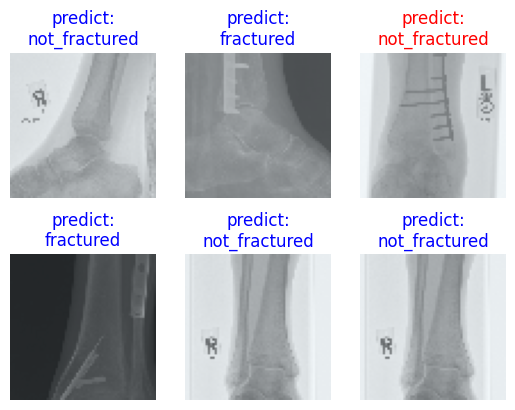

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_model(best_ckpt_path, dataset_val):
    net = dpn92(num_classes=2)
    # 加载模型参数
    param_dict = ms.load_checkpoint(best_ckpt_path)
    ms.load_param_into_net(net, param_dict)
    # 加载验证集的数据进行验证
    data = next(dataset_val.create_dict_iterator())
    images = data["image"]
    labels = data["label"]
    # 预测图像类别
    output = net(data['image'])
    pred = np.argmax(output.asnumpy(), axis=1)

    # 图像分类
    classes = ["fractured", "not_fractured"]

    # 显示图像及图像的预测值
    plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        # 若预测正确，显示为蓝色；若预测错误，显示为红色
        color = 'blue' if pred[i] == labels.asnumpy()[i] else 'red'
        plt.title('predict:\n{}'.format(classes[pred[i]]), color=color)
        picture_show = np.transpose(images.asnumpy()[i], (1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        picture_show = std * picture_show + mean
        picture_show = np.clip(picture_show, 0, 1)
        plt.imshow(picture_show)
        plt.axis('off')

    plt.show()


# 使用测试数据集进行验证
visualize_model(best_ckpt_path=best_ckpt_path, dataset_val=dataset_val)